# Convolutional MNIST VAE

## Installation 

In [12]:
!mkdir figures
!mkdir scripts
%cd /content/scripts
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pyprobml_utils.py
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/lvm_plots_utils.py
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/vae-mnist-conv.ckpt
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/vae_conv_mnist.py
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/vae-mnist-conv-latent-dim-2.ckpt

mkdir: cannot create directory ‘figures’: File exists
mkdir: cannot create directory ‘scripts’: File exists
/content/scripts


In [13]:
%%capture
! pip install --quiet torchvision pytorch-lightning torch test-tube einops umap

In [48]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from pytorch_lightning import LightningModule, Trainer
from einops import rearrange
from lvm_plots_utils import get_random_samples, get_grid_samples, plot_scatter_plot, get_imrange, plot_grid_plot, plot_scatter_plot
import seaborn as sns
from torchvision.utils import make_grid
from vae_conv_mnist import ConvVAE

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
mnist_full = MNIST(".", train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor(),
                                                       transforms.Resize((32,32))]))
dm = DataLoader(mnist_full, batch_size=250)
vis_data = DataLoader(mnist_full, batch_size=5000)
batch = next(iter(vis_data))

## VAE

In [25]:
m = ConvVAE((1, 28, 28), encoder_conv_filters=[28,64,64], decoder_conv_t_filters=[64,28,1], latent_dim=20, kl_coeff=5)
m2 = ConvVAE((1, 28, 28), encoder_conv_filters=[28,64,64], decoder_conv_t_filters=[64,28,1], latent_dim=2, kl_coeff=5)

In [26]:
m.load_state_dict(torch.load("vae-mnist-conv.ckpt"))
m2.load_state_dict(torch.load("vae-mnist-conv-latent-dim-2.ckpt"))

<All keys matched successfully>

In [33]:
m.eval()
m.to(device)
m2.eval()
m2.to(device)

ConvVAE(
  (vae): ConvVAEModule(
    (enc_convs): ModuleList(
      (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(28, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.01)
    )
    (mu_linear): Linear(in_features=1024, out_features=2, bias=True)
    (log_var_linear): Linear(in_features=1024, out_features=2, bias=True)
    (decoder_linear): Linear(in_features=2, out_features=1024, bias=True)
    (dec_t_convs): ModuleList(
      (0): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
      (3): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (4): ConvTranspose2d(64, 28, kernel_size=(3, 3), stride=(1, 1), padd

## Reconstruction

### ConvVAE with latent dim 20

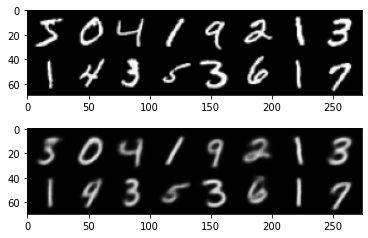

In [ ]:
imgs, _ = batch
imgs = imgs[:16]

fig, axs=plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs), 'c h w -> h w c'))
imgs = imgs.to(device=device)
axs[1].imshow(rearrange(make_grid(m.vae(imgs)[0].cpu()), 'c h w -> h w c'))
plt.show()

### ConvVAE with latent dim 2

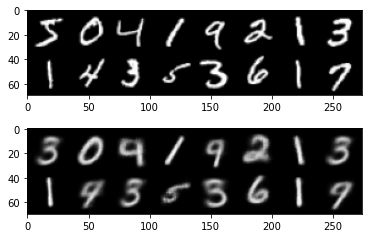

In [29]:
imgs, _ = batch
imgs = imgs[:16]

fig, axs=plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs), 'c h w -> h w c'))
imgs = imgs.to(device=device)
axs[1].imshow(rearrange(make_grid(m2.vae(imgs)[0].cpu()), 'c h w -> h w c'))
plt.show()

## Sampling

### Random samples form truncated unit normal distribution

We sample $z \sim TN(0,1)$ form a truncated normal distribution with a threshold = 5

#### ConvVAE with latent dim 20

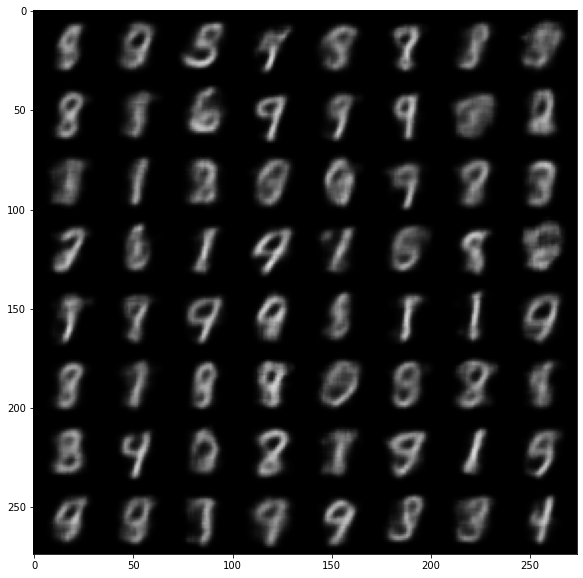

In [30]:
def decoder(z):
  return m.vae.decode(z)

plt.figure(figsize=(10,10))
# Where 5 is the truncation threshold for our truncated normal distribution we are sampling from
imgs= get_random_samples(decoder, 5)
plt.imshow(imgs)

#### ConvVAE with latent dim 2

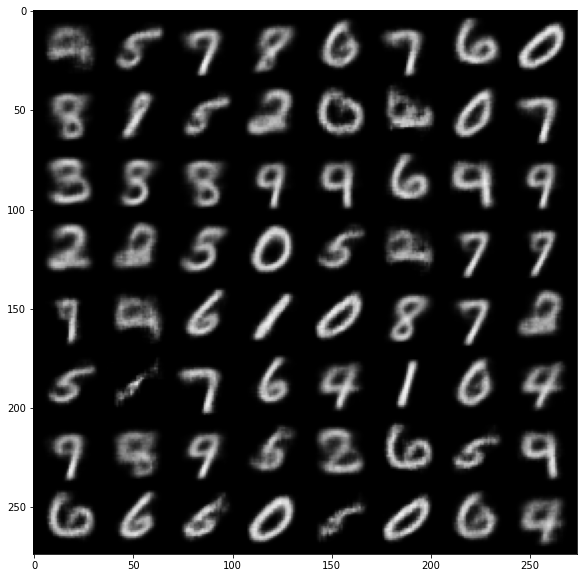

In [52]:
def decoder(z):
  return m2.vae.decode(z)

plt.figure(figsize=(10,10))
# Where 5 is the truncation threshold for our truncated normal distribution we are sampling from
imgs= get_random_samples(decoder, 5)
plt.imshow(imgs)

### Grid Sampling

We let $z = [z1, z2, 0, \ldots, 0]$ and vary $z1, z2$ on a grid

#### ConvVAE with latent dim 20

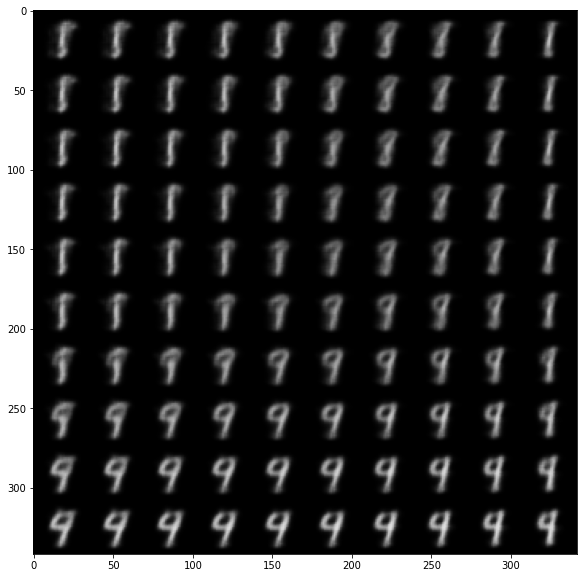

In [ ]:
def decoder(z):
  return m.vae.decode(z)[0]

plt.figure(figsize=(10,10))
plt.imshow(rearrange(make_grid(get_grid_samples(decoder, 20), 10), " c h w -> h w c").cpu())

#### ConvVAE with latent dim 2

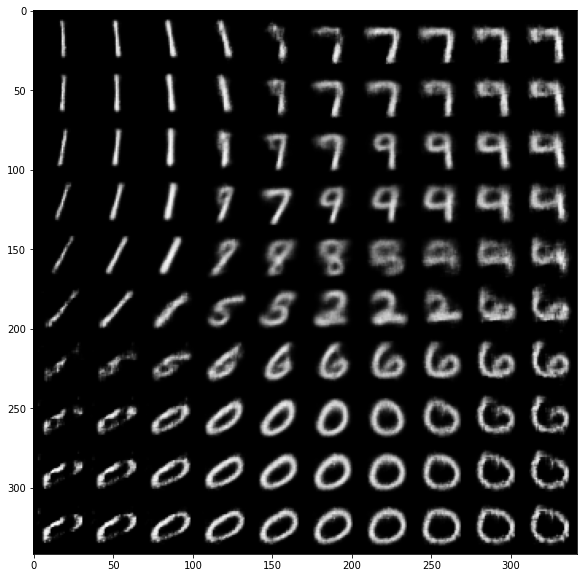

In [51]:
def decoder(z):
  return m2.vae.decode(z)[0]

plt.figure(figsize=(10,10))
plt.imshow(rearrange(make_grid(get_grid_samples(decoder, 20), 10), " c h w -> h w c").cpu())

## 2D Color embedding of latent space

### ConvVAE with latent dim 20

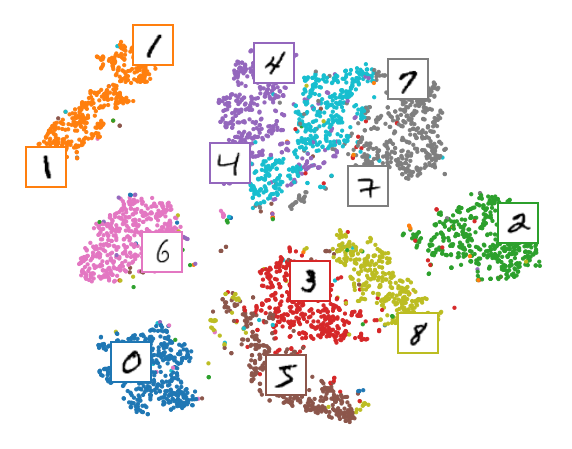

In [10]:
def encoder(img):
  return m.vae.encode(img)[0]

def decoder(z):
  z = z.to(device)
  return rearrange(m.vae.decode(z), "b c h w -> b (c h) w")

plot_scatter_plot(batch, encoder)

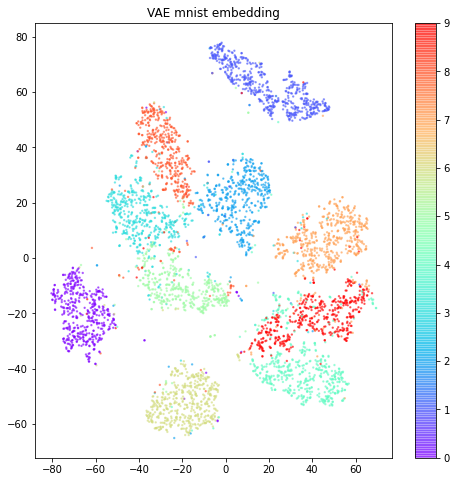

In [11]:
plot_grid_plot(batch, encoder)

### ConvVAE with latent dim 2

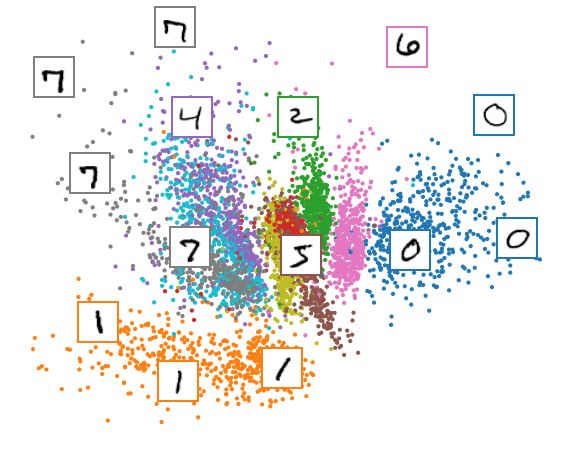

In [49]:
def encoder(img):
  return m2.vae.encode(img)[0].cpu().detach().numpy()

def decoder(z):
  z = z.to(device)
  return rearrange(m2.vae.decode(z), "b c h w -> b (c h) w")

plot_scatter_plot(batch, encoder)

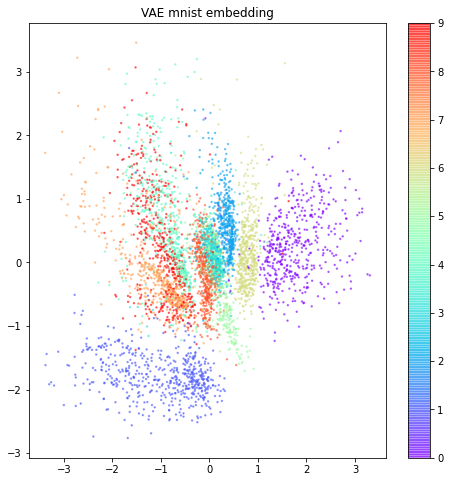

In [50]:
plot_grid_plot(batch, encoder)

## Interpolation 

In [60]:
def encoder(img):
  return m2.vae.encode(img)[0].cpu().detach()

imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[1], z_imgs[0]

### Spherical Interpolation

#### ConvVAE with latent dim 20

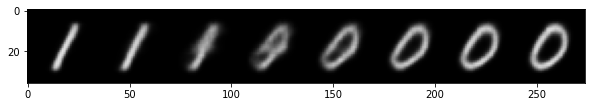

In [65]:
def decoder(z):
  z = z.to(device)
  return rearrange(m.vae.decode(z), "b c h w -> b (c h) w")

def encoder(img):
  return m.vae.encode(img)[0].cpu().detach()

imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[1], z_imgs[3]

plt.figure(figsize=(10,100))
arr = get_imrange(decoder,start,end)
plt.imshow(arr)

#### ConvVAE with latent dim 2

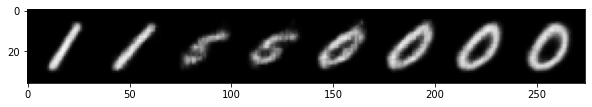

In [69]:
def decoder(z):
  z = z.to(device)
  return rearrange(m2.vae.decode(z), "b c h w -> b (c h) w")

def encoder(img):
  return m2.vae.encode(img)[0].cpu().detach()

imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[1], z_imgs[3]

plt.figure(figsize=(10,100))
arr = get_imrange(decoder,start,end)
plt.imshow(arr)

### Linear Interpolation

#### ConvVAE with latent dim 20

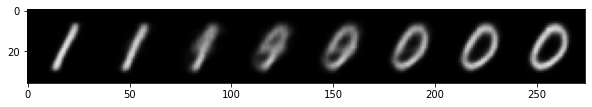

In [67]:
def decoder(z):
  z = z.to(device)
  return rearrange(m.vae.decode(z), "b c h w -> b (c h) w")

def decoder(z):
  z = z.to(device)
  return rearrange(m.vae.decode(z), "b c h w -> b (c h) w")

imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[1], z_imgs[3]

plt.figure(figsize=(10,100))
arr = get_imrange(decoder,start,end, interpolation="linear")
plt.imshow(arr)

#### ConvVAE with latent dim 2

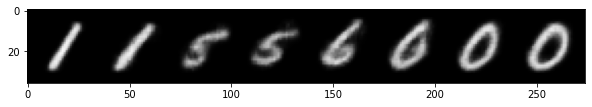

In [70]:
def decoder(z):
  z = z.to(device)
  return rearrange(m2.vae.decode(z), "b c h w -> b (c h) w")

def decoder(z):
  z = z.to(device)
  return rearrange(m2.vae.decode(z), "b c h w -> b (c h) w")

imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[1], z_imgs[3]

plt.figure(figsize=(10,100))
arr = get_imrange(decoder,start,end, interpolation="linear")
plt.imshow(arr)